In [6]:
import pathlib
import sys
#sys.path.append(str(pathlib.Path('..').resolve()))
sys.path.append('..')
from lightgbm import LGBMRegressor
from helpers.model_eval import eval_model
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


root_path = "../"

df = pd.read_csv(root_path + 'data/ISListingsBerlinBrb.csv')
#df = df.fillna('NA')



In [7]:
df

,balcony,barrier_free,builtin_kitchen,cellar,city,creation,energy_certificate,energy_efficiency,garden,guest_toilet,...,lng,number_of_rooms,postcode,price,private_offer,publish_date,quarter,street,tags,title
0,False,NaN,True,NaN,Berlin,2019-10-17T10:48:37.000+02:00,True,D,False,NaN,...,NaN,2.0,10117,5100.00,False,2019-10-17T10:48:37.000+02:00,Mitte (Mitte),NaN,"Einbauküche,Keller,Aufzug",Hochwertig möbliertes Penthouse mit Belvedere ...
1,True,NaN,True,NaN,Berlin,2020-12-02T17:31:02.000+01:00,True,D,False,NaN,...,NaN,2.0,10117,3925.00,False,2020-12-02T17:31:02.000+01:00,Mitte (Mitte),NaN,"Balkon/Terrasse,Einbauküche,Keller,Gäste-WC,Au...",Stadtresidenz mit edlem Interieur in herrschaf...
2,True,NaN,True,NaN,Berlin,2020-11-20T12:45:34.000+01:00,NaN,NaN,False,NaN,...,13.33335,3.0,10623,1872.10,False,2020-11-20T12:45:34.000+01:00,Charlottenburg (Charlottenburg),Wegelystrasse,"Balkon/Terrasse,Einbauküche,Keller,Aufzug,Stuf...",No.1 Charlottenburg - Wohnung zum Erstbezug
3,False,NaN,False,NaN,Berlin,2021-01-07T09:29:41.000+01:00,True,D,True,NaN,...,13.48007,2.0,13125,548.60,False,2021-01-07T09:29:41.000+01:00,Karow (Weißensee),Straße 43,"Garten,Stufenlos",Moderne 2-Zimmerwohnung mit Garten im ruhigem ...
4,False,NaN,True,NaN,Berlin,2021-01-07T09:33:14.000+01:00,True,D,False,NaN,...,13.47814,3.0,13125,650.88,False,2021-01-07T09:33:14.000+01:00,Karow (Weißensee),Straße 43,Einbauküche,Helle 3-Zimmerwohnung mit Einbauküche in Karow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883,True,NaN,True,NaN,Berlin,2020-12-30T13:13:46.000+01:00,NaN,NaN,False,NaN,...,13.52884,3.0,10318,965.00,False,2020-12-30T13:13:46.000+01:00,Karlshorst (Lichtenberg),Godesberger Str.,"Balkon/Terrasse,Einbauküche,Keller,Aufzug,Stuf...",Altersgerechtes Wohnen im Objekt Residenz Karl...
1884,False,NaN,False,NaN,Berlin,2011-10-14T12:42:19.000+02:00,True,NaN,False,NaN,...,NaN,5.0,10119,2167.00,True,2011-10-14T12:42:19.000+02:00,Mitte (Mitte),NaN,Keller,Wunderschöne große 5 Zimmer Altbauwohnung in z...
1885,True,NaN,True,NaN,Berlin,2021-01-04T11:54:13.251+01:00,True,NaN,False,NaN,...,13.20482,2.0,13597,1062.00,True,2021-01-04T11:54:13.251+01:00,Spandau (Spandau),Grunewaldstr.,"Balkon/Terrasse,Einbauküche,Keller",Exclusives Dachgeschoß100qm mit Sonnen-Terrass...
1886,True,NaN,False,NaN,Berlin,2010-01-25T12:27:31.000+01:00,NaN,NaN,False,NaN,...,13.57744,2.0,12555,610.00,True,2010-01-25T12:27:31.000+01:00,Köpenick (Köpenick),Puchanstr.,"Balkon/Terrasse,WG-geeignet",sehr schöne 2 Zimmerwohnung zentrale Lage in ...


Training until validation scores don't improve for 100 rounds
[50]	valid_0's mape: 0.19145
[100]	valid_0's mape: 0.185818
[150]	valid_0's mape: 0.183196
[200]	valid_0's mape: 0.181179
[250]	valid_0's mape: 0.180251
[300]	valid_0's mape: 0.179732
[350]	valid_0's mape: 0.179303
[400]	valid_0's mape: 0.178877
[450]	valid_0's mape: 0.178915
[500]	valid_0's mape: 0.17857
[550]	valid_0's mape: 0.17835
[600]	valid_0's mape: 0.178275
Early stopping, best iteration is:
[528]	valid_0's mape: 0.178099


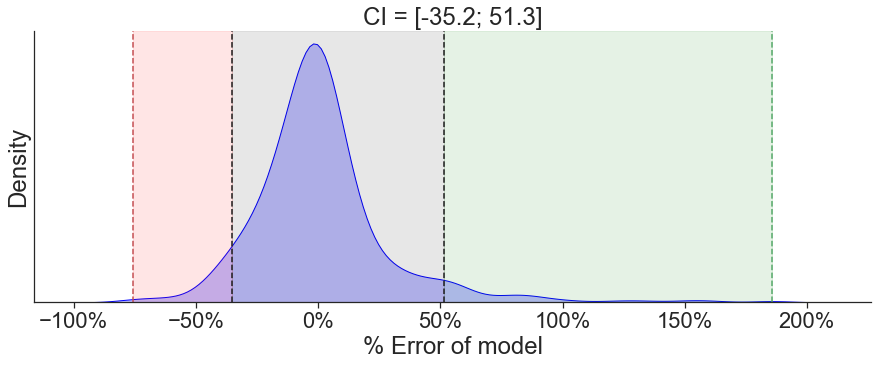

In [4]:
cat_cols = ['postcode', 'quarter', 'city', 'balcony', 'barrier_free', 'builtin_kitchen', 'cellar', 'garden',
            'guest_toilet', 'lift', 'street', 'energy_certificate', 'energy_efficiency']

X = df.drop('title tags publish_date price creation housenr listing_id'.split(), axis=1)
y = df.price/(df.living_space+1)

add_no_cat = 'barrier_free cellar energy_certificate energy_efficiency guest_toilet'.split()
X[add_no_cat] = X[add_no_cat].fillna('NO')
X[cat_cols] = X[cat_cols].fillna('NA')
numcols = X.loc[:, ~X.columns.isin(cat_cols)].columns

X[cat_cols] = X[cat_cols].astype('category')

for cc in cat_cols:
    X[cc] = X[cc].cat.codes
xtrain, xval, ytrain, yval = train_test_split(X, y, random_state=42)




# %%
reg = LGBMRegressor(objective='MAPE', n_estimators=1000)
reg.fit(xtrain, ytrain, eval_set=(xval, yval), eval_metric='MAPE', verbose=50, early_stopping_rounds=100)

# %%
preds = reg.predict(xval)

# %%
evaldf = eval_model(yval, reg.predict(xval))


In [9]:
head25 = evaldf.sort_values('ape').head(25).index
pd.concat((xval.loc[head25], yval.loc[head25]), axis=1)

,balcony,barrier_free,builtin_kitchen,cellar,city,energy_certificate,energy_efficiency,garden,guest_toilet,lat,lift,living_space,lng,number_of_rooms,postcode,private_offer,quarter,street,0
163,0,0,0,0,0,1,8,0,0,NaN,0,22.00,NaN,1.0,19,False,67,489,64.782609
705,1,0,1,0,0,1,8,0,0,NaN,0,160.79,NaN,4.0,46,False,75,489,58.975338
331,1,0,1,0,0,1,8,0,0,52.52415,0,30.00,13.41812,2.0,3,False,53,521,64.193548
332,0,0,1,0,0,0,8,0,0,52.52418,0,21.00,13.41822,1.5,3,False,53,521,67.727273
707,1,0,1,0,0,0,8,0,0,NaN,0,116.00,NaN,3.0,29,False,14,489,35.897436
350,1,0,0,0,0,1,8,1,0,NaN,0,65.00,NaN,2.0,147,False,34,489,17.727273
985,1,0,1,0,0,0,8,0,0,52.49318,0,150.00,13.47788,4.0,6,False,23,727,26.490066
1767,1,0,1,0,1,0,8,0,0,52.38778,0,33.00,13.09474,1.0,188,False,4,317,20.117647
289,1,0,1,0,0,0,8,0,0,52.49203,0,84.26,13.47821,2.0,6,True,23,726,22.236101
1278,1,0,1,0,0,1,8,1,0,NaN,0,137.00,NaN,4.0,178,True,15,489,25.362319


In [4]:
# Underpriced:
undervalued = evaldf.sort_values('ape').join([df, yval*xval.living_space]).rename({0: 'price'}, axis=1).drop(['tags', 'creation', 'publish_date', 'energy_certificate'], axis=1)
undervalued.tail(25)


,real,pred,ape,balcony,barrier_free,builtin_kitchen,cellar,city,energy_efficiency,garden,...,living_space,lng,number_of_rooms,postcode,price,private_offer,quarter,street,title,price
609,5.976531,8.978100,0.502226,False,NaN,False,NaN,Berlin,B,False,...,57.80,13.50635,2.0,10319,351.42,False,Friedrichsfelde (Lichtenberg),Sewanstr.,Wohnung mit WBS für 2 Räume (2 Personen),345.443469
32,9.523810,14.535918,0.526271,True,NaN,True,NaN,Berlin,NaN,False,...,83.00,13.56441,2.0,12526,800.00,True,Bohnsdorf (Treptow),Rosenrotweg,2 Zimmer - Gemütliche Familienwohnung,790.476190
1878,10.299122,15.737610,0.528054,True,NaN,False,NaN,Berlin,NaN,False,...,54.83,13.43996,2.0,10409,575.00,False,Prenzlauer Berg (Prenzlauer Berg),Erich-Weinert-Str.,Modernisierte 2-Zimmer-Wohnung zu vermieten!,564.700878
1686,8.965424,13.882635,0.548464,False,NaN,True,NaN,Berlin,NaN,False,...,58.00,13.20881,2.0,13587,528.96,False,Spandau (Spandau),Streitstrasse,helle 2 Zimmerwohnung in Spandau,519.994576
544,5.255677,8.219002,0.563833,True,NaN,False,NaN,Berlin,D,False,...,70.34,13.44290,2.5,12353,374.94,False,Buckow (Neukölln),Mollnerweg,WBS mit besonderem Wohnbedarf benötigt - Handw...,369.684323
1454,12.337662,19.341198,0.567655,False,NaN,True,NaN,Berlin,NaN,False,...,76.00,13.38418,2.0,10963,950.00,False,Kreuzberg (Kreuzberg),Stresemannstraße,Großzügiges 2-Zimmer Appartement mit EBK direk...,937.662338
1700,7.375000,11.588797,0.571362,False,NaN,True,NaN,Berlin,NaN,False,...,39.00,NaN,1.0,10551,295.00,False,Tiergarten (Tiergarten),NaN,Tauschwohnung: Super günstige 1 Zimmerwohnung ...,287.625000
339,8.247191,13.003795,0.576754,False,NaN,True,NaN,Berlin,NaN,False,...,88.00,13.19954,3.0,13585,734.00,True,Spandau (Spandau),Schönwalder Straße,"Hochwertige 3-Zimmer-Wohnung, teilmöbliert, mi...",725.752809
433,5.258977,8.368312,0.591243,False,NaN,False,NaN,Berlin,D,False,...,75.03,13.55800,4.0,12679,399.84,False,Marzahn (Marzahn),Ludwig-Renn-Straße,Super Aussicht,394.581023
674,6.319444,10.116744,0.600891,True,NaN,False,NaN,Berlin,B,False,...,35.00,13.51073,1.0,12487,227.50,False,Johannisthal (Treptow),Melli-Beese-Straße,1 Zimmer Wohnung mit WBS - Beispielwohnung -,221.180556


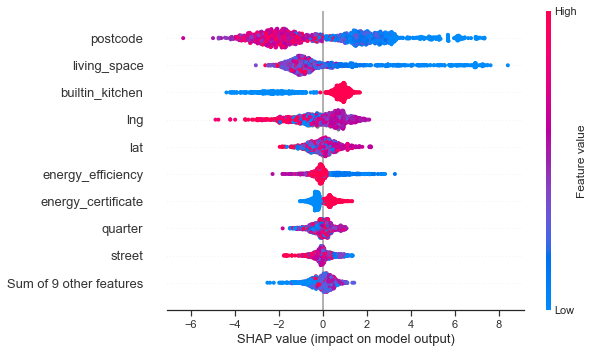

In [6]:
import shap

explainer = shap.Explainer(reg)
shap_values = explainer(xtrain)

# visualize the first prediction's explanation
shap.plots.beeswarm(shap_values)



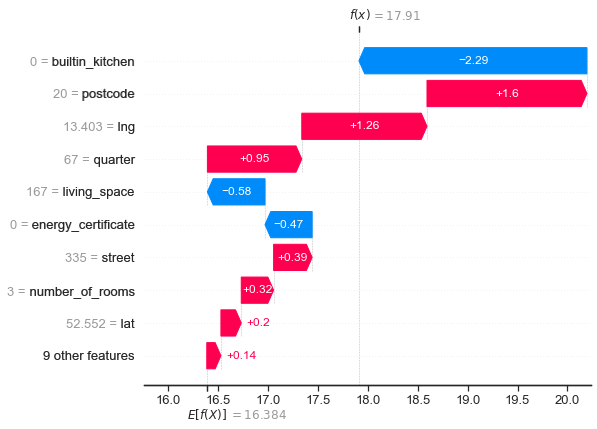

In [7]:
shap.plots.waterfall(shap_values[42])

# Heading

In [11]:
a = np.array([1,2,3])

a.all()

In [1]:
from rich.console import Console
c = Console()

In [3]:
c.print("[white on red] ALERT! [/]")
c.print("[white on green] GOOD! [/]")